In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helpers import  read_N_prepare_data, plot_item_ratings_freq, plot_user_ratings_freq, calc_similarity, top_neighbours
from helpers import get_item, get_items, get_user, get_users, get_user_item

# Week 1

### Data preprocessing

In [4]:
def clean_data(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.astype({'user_id': 'str', 'item_id': 'str', 'rating': 'float'}, copy=False)
    df.drop(['timestamp'], axis=1, inplace=True)
    print("Data points initially:", df.shape[0])
    df.drop_duplicates(inplace=True, keep='first')
    print("Data points after removing duplicates:", df.shape[0])
    
    df.dropna(inplace=True)

    # invalid user_id or item_id
    t1 = df.loc[df['item_id'] == ''].shape[0] + df.loc[df['user_id'] == ''].shape[0]
    assert t1 == 0
    print("No invalid user_id or item_id")
    # invalid ratings
    t2 = df.loc[df['rating'] < 0].shape[0] + df.loc[df['rating'] > 5].shape[0]  
    assert t2 == 0
    print("No invalid ratings")

    print("Data points after cleaning:", df.shape[0])

In [5]:
# Preapre data
df_t = pd.read_csv('data/test.tsv', sep='\t')
df = pd.read_csv('data/train.tsv', sep='\t')
# clean data
print(''.join(['-']*50))
print("Cleaning test split:")
clean_data(df_t)
print(''.join(['-']*50))
print("Cleaning training split:")
clean_data(df)
print(''.join(['-']*50))

print("Training and Test compatibility check:")


all_users_tr = set(df['user_id'])
print('users in training : ',len(all_users_tr))
all_items_tr = set(df['item_id'])
print('items in training: ',len(all_items_tr))


all_users_tst = set(df_t['user_id']) 
all_items_tst = set(df_t['item_id'])


# check if all users in test are in training
users_not_in_tr = all_users_tst.difference(all_users_tr)
print('users in test but not in training(dropping): ', len(users_not_in_tr))

# check if all items in test are in training
items_not_in_tr = all_items_tst.difference(all_items_tr)
print('items in test but not in training(dropping): ', len(items_not_in_tr))

# drop users not in training
df_t = df_t[~df_t['user_id'].isin(users_not_in_tr)]

# drop items not in training
df_t = df_t[~df_t['item_id'].isin(items_not_in_tr)]


all_users_tst = list(set(df_t['user_id']))
all_items_tst = list(set(df_t['item_id']))
print('users in test: ',len(all_users_tst))
print('items in test: ',len(all_items_tst))

#common
common_users = set(all_users_tr).intersection(all_users_tst)
common_items = set(all_items_tr).intersection(all_items_tst)
print("Common users: ", len(common_users))
print("Common items: ", len(common_items))

#all
all_users = set(all_users_tr).union(all_users_tst)
all_items = set(all_items_tr).union(all_items_tst)
print("All users: ", len(all_users))
print("All items: ", len(all_items))


test_indx = df_t.set_index(['user_id', 'item_id']).index
train_indx = df.set_index(['user_id', 'item_id']).index
overlap = 0
for u in common_users:
    for i in common_items:
        if (u,i) in test_indx and (u,i) in train_indx:
            overlap += 1
print("Overlap between training and test data: ", overlap)

print(''.join(['-']*50))
print("Final test data shape: ", df_t.shape)
print("Final training data shape: ", df.shape)





--------------------------------------------------
Cleaning test split:
Data points initially: 3000
Data points after removing duplicates: 1822
No invalid user_id or item_id
No invalid ratings
Data points after cleaning: 1822
--------------------------------------------------
Cleaning training split:
Data points initially: 11000
Data points after removing duplicates: 9913
No invalid user_id or item_id
No invalid ratings
Data points after cleaning: 9913
--------------------------------------------------
Training and Test compatibility check:
users in training :  800
items in training:  509
users in test but not in training(dropping):  0
items in test but not in training(dropping):  9
users in test:  427
items in test:  404
Common users:  427
Common items:  404
All users:  800
All items:  509
Overlap between training and test data:  0
--------------------------------------------------
Final test data shape:  (1728, 3)
Final training data shape:  (9913, 3)


### Data Statistics

In [7]:
# TEST DUPLICATES
df_t_raw = pd.read_csv('data/test.tsv', sep='\t')
df_t_raw.shape
df_t_raw.groupby(['user_id','item_id','rating','timestamp']).size().reset_index(name='count').sort_values(by='count', ascending=False).head(5)

,user_id,item_id,rating,timestamp,count
1512,AHEJYPLN7DMCYRQ2KCWQ5YIY6JDA,B0BPKH4HB2,5.0,1669857856601,6
959,AG5CLB4M2P4GCGANQS4WS3JGHFOQ,B09R2TMLJR,5.0,1656815832888,5
1088,AGC2Y4SQPG23KHUYXHSMOKIPJVGQ,B0064RTS0G,5.0,1585166179129,5
1757,AHUIUCGSUO6B2KRQLQ2UWRYXTH5Q,B0BKR2ZM9X,5.0,1584845977235,5
767,AFNKANPQUS5G3ENXFLAJ4CHWQGFQ,B081592T7F,5.0,1587658475788,5


In [8]:
# TRAIN DUPLICATES
df_t_raw = pd.read_csv('data/train.tsv', sep='\t')
df_t_raw.shape
df_t_raw.groupby(['user_id','item_id','rating','timestamp']).size().reset_index(name='count').sort_values(by='count', ascending=False).head(5)

,user_id,item_id,rating,timestamp,count
762,AECRFIY3HZZG5KMU424HTLAKDGFA,B07DK59QNR,5.0,1529681473598,4
202,AE3Y65VROR3YICKMO6OJJ2LLN7RQ,B09BF8XDF4,5.0,1299875655000,4
9204,AHP54DEEFACVFPIFX7KZ3P32ZYVQ,B01DE4D4LU,5.0,1519671505067,3
9829,AHYQKMLIXHKFDHC7K2Y4JXM4YLOQ,B013ZHK4DM,5.0,1523749482759,3
1187,AEHPI7DGK45GM4JO4PP25BE3RZJQ,B09396NY1C,5.0,1424281371000,3


item_id
B0BSGM6CQ9    158
B0BPJ4Q6FJ    156
B09857JRP2    143
B0BCK6L7S5    132
B08R5GM6YB    123
B0BTC9YJ2W    122
B08SJY4T7K     95
B0B95V41NR     92
B004XNK7AI     89
B09V91H5XM     85
Name: count, dtype: int64
item_id
B08Y6PVK2L    2
B073RTT48C    2
B08PBNXZYP    2
B0B63DPVDK    2
B075MCRFYZ    2
B0C5CTX5LZ    1
B0BNCDVD4M    1
B0B2LMZ9RT    1
B07DVX841V    1
B07KRZ1HH8    1
Name: count, dtype: int64


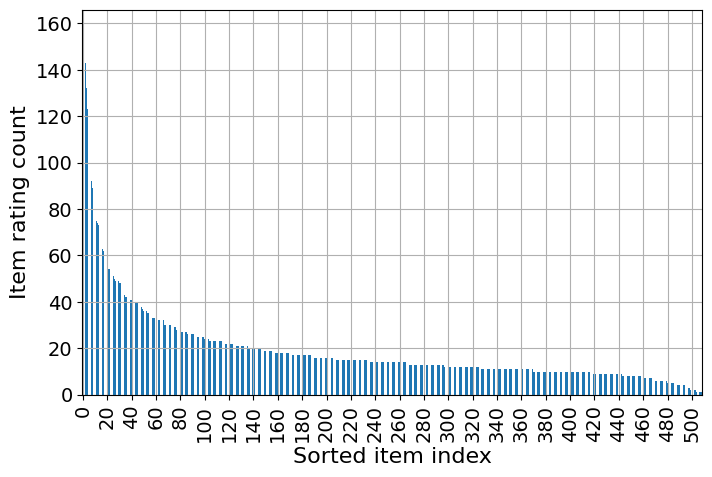

In [9]:
# ITEM RATINGS FREQUENCY
p = plot_item_ratings_freq(df)


user_id
AF7CC34DK36SQJS7WXI44DREGWJA    48
AG5ZVXXHEXDYUUODSEQC4XXV7DPA    43
AFJQQWO6VAZCTTY3GXNB3SEUU34Q    43
AGVT5E2C6WNOCFYSLOCPAPBJOIKQ    41
AG4ZLTRHVAZRU33BPY5Y643IZXPQ    40
AHR6CSQFJVG5AHI25CP4NTJDEZFQ    38
AG6ATLCKETNYRKL6GCQV35CSSGPA    36
AHJQIRE3KBRMPLVEGQNUOTYILZDA    36
AHNG3NRGEDYO7E44QMYDHMBADPBA    35
AFDAU5M5NRUN4LYLI7N4YROKYLWA    34
Name: count, dtype: int64
user_id
AHMMZCKZMV7U5SPYVE6IG2YACR7Q    2
AFFOT7AORQAWKU6KKPDHR3FOA5AA    1
AF2MGAQBAT3E4XQC7NNAQFYG4MIQ    1
AEXXX2MQRH3AHZMBZBP4RDNGRRWQ    1
AHMUAUOHLITDKIKI4C3KVRWIBMAQ    1
AESA6T5VF3ADXH5GYRX2RDMN6I6Q    1
AGMYRILPTJDOK7WL5OYHYGRYVXMQ    1
AFGJ42MV2H2CHEZNN3JPQ3RSYUHQ    1
AEMZMINSQYQBEDD3TPDQZZFFWIQA    1
AGDEYWGZKNGR36MRO7ZT3AB45AXA    1
Name: count, dtype: int64


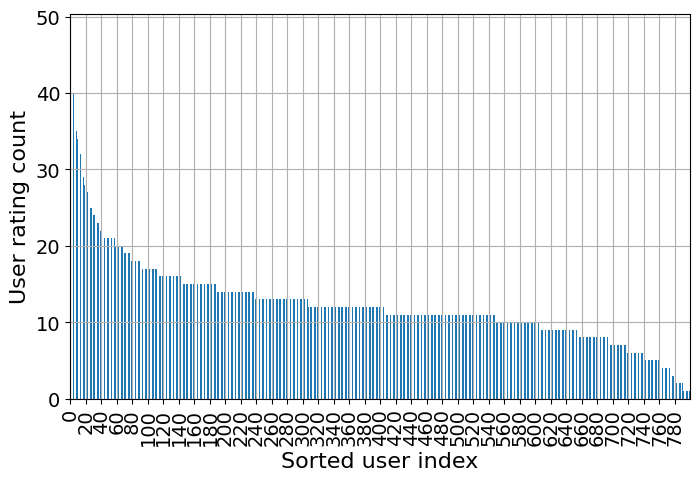

In [10]:
# USER RATINGS FREQUENCY
plot_user_ratings_freq(df)

In [11]:
# Top 5 most rated items
user_cnts = df.copy()
sums = user_cnts.groupby('item_id').sum()
top_rting_cnt_5 = user_cnts.groupby('item_id').count().sort_values(by='user_id', ascending=False).head(5)
buff = sums.loc[top_rting_cnt_5.index]
buff['rating'] = buff['rating'].values/top_rting_cnt_5['rating'].values

for i, r in buff.iterrows():
    print("Item: ", i, " Avg Rating: ", round(r['rating'], 2))
#for r_cnt in top_rting_cnt_5['rating'].values:
    


Item:  B0BSGM6CQ9  Avg Rating:  4.69
Item:  B0BPJ4Q6FJ  Avg Rating:  4.74
Item:  B09857JRP2  Avg Rating:  4.77
Item:  B0BCK6L7S5  Avg Rating:  4.3
Item:  B08R5GM6YB  Avg Rating:  4.5


# Week 2

In [4]:
#TOPOP
def topPopK(df,r,k):
    top = df.loc[df['rating'] > r].groupby(['item_id']).count().sort_values(by='rating', ascending=False).head(k)
    
    # top['item_id'] = top.index
    # top.set_index('user_id', inplace=True)
    top.reset_index(inplace=True)
    top.drop(['user_id','rating'], axis=1, inplace=True)
    return top
topPopK(df,3,10)

,item_id
0,B0BPJ4Q6FJ
1,B0BSGM6CQ9
2,B09857JRP2
3,B0BTC9YJ2W
4,B08R5GM6YB
5,B0BCK6L7S5
6,B0B95V41NR
7,B004XNK7AI
8,B09V91H5XM
9,B08SJY4T7K


## Surprise

In [31]:
#LOAD DATA
from surprise import KNNWithMeans
from surprise import Dataset, NormalPredictor, Reader
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import accuracy

# A reader is still needed but only the rating_scale param is required.
reader = Reader(rating_scale=(1, 5))
# The columns must correspond to user id, item id and ratings (in that order).
data_train_pd = Dataset.load_from_df(df[["user_id", "item_id", "rating"]], reader)

# change dataformat for test
data_test = []
for i,u in df_t.iterrows():
    uid = u['user_id']
    iid = u['item_id']
    r_ui= u['rating']
    data_test.append((uid,iid,r_ui))

### KNN

In [32]:
# PARAM SEARCH
search = False
if search:
    knn_param_grid = {'k': [2, 5, 10, 15, 20],
                    'sim_options': {
                        'name': ['cosine', 'pearson'],
                        'user_based': [True]},
                    'verbose': [False]
                    }

    knn_gs = GridSearchCV(KNNWithMeans, knn_param_grid, measures=['rmse'], cv=5 )
    knn_gs.fit(data_train_pd)
    knn_gs_results_df = pd.DataFrame.from_dict(knn_gs.cv_results)

    # best RMSE score
    print(knn_gs.best_score["rmse"])

    # combination of parameters that gave the best RMSE score
    bst_params = knn_gs.best_params["rmse"]
    print(bst_params)

    K = bst_params['k']
    sim_options = bst_params['sim_options']
else:
    K = 20
    sim_options = {'name': 'cosine', 'user_based': True}
knn_algo = KNNWithMeans(k=K, sim_options=sim_options)
knn_algo = knn_algo.fit(data_train_pd.build_full_trainset())

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [33]:
# Grid search results
if search:
    to_drop_cols = [ col for col in knn_gs_results_df.columns if ('time' in col) ]
    to_drop_cols += ['param_verbose','params']
    knn_gs_results_df.drop(columns=to_drop_cols, inplace=True)
    knn_gs_results_df

In [34]:
# Predict test data
knn_preds = knn_algo.test(data_test)

### SVD

In [35]:
from surprise import SVD
# PARAM SEARCH
search = False
if search:
    svd_param_grid = {'n_factors': [2, 5, 10, 15, 20, 30],
                    'n_epochs': [5, 10, 15, 20, 30],
                    'verbose': [False]
                    }

    svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse'], cv=5 )
    svd_gs.fit(data_train_pd)
    svd_gs_results_df = pd.DataFrame.from_dict(svd_gs.cv_results)

    #best RMSE score
    print(svd_gs.best_score["rmse"])

    #combination of parameters that gave the best RMSE score
    bst_params = svd_gs.best_params["rmse"]
    print(bst_params)

    n_factors = bst_params['n_factors']
    n_epochs = bst_params['n_epochs']
else:
    n_factors = 2
    n_epochs = 20

svd_algo = SVD(n_factors=n_factors, n_epochs=n_epochs)
svd_algo = svd_algo.fit(data_train_pd.build_full_trainset())

In [36]:
# Grid search results
if search:
    to_drop_cols = [ col for col in svd_gs_results_df.columns if ('time' in col) ]
    to_drop_cols += ['param_verbose','params']
    svd_gs_results_df.drop(columns=to_drop_cols, inplace=True)
    svd_gs_results_df.columns
    svd_gs_results_df

In [37]:
# Predict Test data
svd_preds = []
for i in data_test:
    pred = svd_algo.predict(uid = i[0], iid = i[1], r_ui = i[2], verbose=False)
    if pred.details['was_impossible']:
        print('User or item is unkown: \n user: ',uid,' \n item: ',iid)
    svd_preds.append(pred)

# Week 3

#### RMSE for test predictions

In [38]:
accuracy.rmse(knn_preds)
accuracy.rmse(svd_preds)
pass

RMSE: 1.0555
RMSE: 0.9721


### Recommend top 10 for test users

In [ ]:
# Train split to binary
df_t_bin = df_t.copy()
# to binary, and sort by rating
df_t_bin.sort_values(by=['user_id', 'rating'], inplace=True, ascending=[True, False])
df_t_bin.loc[df_t_bin['rating'] < 4, 'rating'] = 0
df_t_bin.loc[df_t_bin['rating'] >= 4, 'rating'] = 1
df_t_bin.set_index('user_id', inplace=True)
df_t_bin.head(10)

,item_id,rating
user_id,,
AE23LDQTB7L76AP6E6WPBFVYL5DA,B0928HW2P4,1.0
AE23LDQTB7L76AP6E6WPBFVYL5DA,B0B95V41NR,1.0
AE23LDQTB7L76AP6E6WPBFVYL5DA,B09198262S,1.0
AE23LDQTB7L76AP6E6WPBFVYL5DA,B0B8F6LD9F,1.0
AE23LDQTB7L76AP6E6WPBFVYL5DA,B00CGFRJ2Y,1.0
AE23LDQTB7L76AP6E6WPBFVYL5DA,B0BPJ4Q6FJ,1.0
AE23LDQTB7L76AP6E6WPBFVYL5DA,B008BPI2OW,1.0
AE23LDQTB7L76AP6E6WPBFVYL5DA,B0BG95DG2H,1.0
AE2BV2H57ERXAPW7SOAXFLWA2S2Q,B07L6RCDP7,1.0


In [40]:
# relavant items count
relevant_cnt_tst = df_t_bin.groupby(['user_id']).sum()
relevant_cnt_tst.drop(columns=['item_id'], inplace=True)
# sort
relevant_cnt_tst.sort_values(by=['rating'], inplace=True, ascending=False)
#relevant_cnt_tst.columns = ['relevant_cnt']
relevant_cnt_tst.head(5)

,rating
user_id,
AEMSFZ4NLED647BP3ZCQEY3FNGKA,23.0
AGMYRILPTJDOK7WL5OYHYGRYVXMQ,13.0
AHMMZCKZMV7U5SPYVE6IG2YACR7Q,13.0
AF2MGAQBAT3E4XQC7NNAQFYG4MIQ,13.0
AHTIEJX7M6WFSN6ZAZIAZU7UBWUA,13.0


In [41]:
# Define missing entries
indxs_in_train = df.set_index(['user_id','item_id']).index

# (uid,iid) pairs not training, where
#  uids from test and iids from training
missing_entries = []
for u in all_users_tst:
    for i in all_items_tst:
        if (u,i) not in indxs_in_train:
            missing_entries.append((u,i,0))

#### KNN

In [42]:
# Predict Missing
# much faster with test method
missing_preds = knn_algo.test(missing_entries)

uids = []
iids = []
pred_rtings = []
for p in missing_preds:
    uids.append(p.uid)
    iids.append(p.iid)
    pred_rtings.append(p.est)

# predicted ratings for all test users, 
# and all training items without the ones given in training split
missing_df = pd.DataFrame({'user_id':uids, 'item_id':iids, 'rating':pred_rtings})
missing_df.sort_values(by=['user_id', 'rating'], inplace=True, ascending=[True, False])


recommended_knn_10 = pd.DataFrame(columns=['user_id','item_id'])
recommended_knn_10.set_index(['user_id'], inplace=True)
a = 0
for u in all_users_tst:
    recom = missing_df.loc[missing_df['user_id'] == u].head(10)
    recommended_knn_10 = pd.concat([recommended_knn_10,recom])

C:\Users\newma\AppData\Local\Temp\ipykernel_25360\1218529328.py:24: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  recommended_knn_10 = pd.concat([recommended_knn_10,recom])


In [43]:
P = recommended_knn_10.copy()
P.set_index('user_id', inplace=True)
P.columns = ['item_id','hit']
P['hit_indx'] = np.full(len(P), -1)
P['hit'] = np.zeros(len(P))
T = df_t_bin.copy()

unique_user_hits = 0
us = []
all_hits = 0
all_preds = 0
for u in all_users_tst:
    user_hit = False
    recom_items = P.loc[u]
    recom_items = recom_items['item_id']
    recom_items.reset_index(drop=True, inplace=True)
    
    seen_items = T.loc[u]['item_id']
    all_preds += len(recom_items)
    for itm in seen_items:    
        #print(itm)
        if itm in recom_items.values:
            P.loc[(P.index == u) & (P['item_id'] == itm), 'hit'] = 1
            P.loc[(P.index == u) & (P['item_id'] == itm), 'hit_indx'] = recom_items[recom_items == itm].index[0]+1
            all_hits += 1
            user_hit = True
            
        # else:
        #     P.loc[(P.index == u) & (P['item_id'] == itm), 'hit'] = 0
    if user_hit:
        unique_user_hits += 1
        us.append(u)
    

print("hits: ",all_hits," out of ",all_preds, " predictions")
print("Unique users with hits: ",unique_user_hits)

print("hit rate: ",unique_user_hits/len(all_users_tst))



#PRECISSION
precision = P.groupby('user_id')['hit'].sum().sort_values(ascending=False).sum()
precision = precision/10
precision = precision/len(all_users_tst)
print("Precision@10: ", round(precision,4))

#MAP
ap = P[P['hit_indx'] != -1].copy()#  P.copy()
ap['hit'] = ap['hit']/ap['hit_indx']
ap = ap.groupby('user_id')['hit'].sum().sort_values(ascending=False).sum()
map = ap/len(all_users_tst)
print("MAP: ", round(map,4))

#MRR
buff = P[P['hit_indx'] != -1].copy()
min_indxs = buff.groupby('user_id')['hit_indx'].min().values
mrr = 1/min_indxs
mrr = mrr.sum()/len(all_users_tst)
print("MRR: ", round(mrr,4))

hits:  38  out of  4270  predictions
Unique users with hits:  35
hit rate:  0.08196721311475409
Precision@10:  0.0089
MAP:  0.0316
MRR:  0.0299


#### SVD


In [44]:
# Predict Missing
# much faster with test method
missing_preds = svd_algo.test(missing_entries)

uids = []
iids = []
pred_rtings = []
for p in missing_preds:
    uids.append(p.uid)
    iids.append(p.iid)
    pred_rtings.append(p.est)

# predicted ratings for all test users, 
# and all training items without the ones given in training split
missing_df = pd.DataFrame({'user_id':uids, 'item_id':iids, 'rating':pred_rtings})
missing_df.sort_values(by=['user_id', 'rating'], inplace=True, ascending=[True, False])


recommended_svd_10 = pd.DataFrame(columns=['user_id','item_id'])
recommended_svd_10.set_index(['user_id'], inplace=True)
a = 0
for u in all_users_tst:
    recom = missing_df.loc[missing_df['user_id'] == u].head(10)
    recommended_svd_10 = pd.concat([recommended_svd_10,recom])

C:\Users\newma\AppData\Local\Temp\ipykernel_25360\146140264.py:24: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  recommended_svd_10 = pd.concat([recommended_svd_10,recom])


In [45]:
P = recommended_svd_10.copy()
P.set_index('user_id', inplace=True)
P.columns = ['item_id','hit']
P['hit_indx'] = np.full(len(P), -1)
P['hit'] = np.zeros(len(P))
T = df_t_bin.copy()

unique_user_hits = 0
us = []
all_hits = 0
all_preds = 0
for u in all_users_tst:
    user_hit = False
    recom_items = P.loc[u]
    recom_items = recom_items['item_id']
    recom_items.reset_index(drop=True, inplace=True)
    
    seen_items = T.loc[u]['item_id']
    all_preds += len(recom_items)
    for itm in seen_items:    
        #print(itm)
        if itm in recom_items.values:
            P.loc[(P.index == u) & (P['item_id'] == itm), 'hit'] = 1
            P.loc[(P.index == u) & (P['item_id'] == itm), 'hit_indx'] = recom_items[recom_items == itm].index[0]+1
            all_hits += 1
            user_hit = True
            
        # else:
        #     P.loc[(P.index == u) & (P['item_id'] == itm), 'hit'] = 0
    if user_hit:
        unique_user_hits += 1
        us.append(u)
    

print("hits: ",all_hits," out of ",all_preds, " predictions")
print("Unique users with hits: ",unique_user_hits)

print("hit rate: ",unique_user_hits/len(all_users_tst))



#PRECISSION
precision = P.groupby('user_id')['hit'].sum().sort_values(ascending=False).sum()
precision = precision/10
precision = precision/len(all_users_tst)
print("Precision@10: ", round(precision,4))

#MAP
ap = P[P['hit_indx'] != -1].copy()#  P.copy()
ap['hit'] = ap['hit']/ap['hit_indx']
ap = ap.groupby('user_id')['hit'].sum().sort_values(ascending=False).sum()
map = ap/len(all_users_tst)
print("MAP: ", round(map,4))

#MRR
buff = P[P['hit_indx'] != -1].copy()
min_indxs = buff.groupby('user_id')['hit_indx'].min().values
mrr = 1/min_indxs
mrr = mrr.sum()/len(all_users_tst)
print("MRR: ", round(mrr,4))

hits:  38  out of  4270  predictions
Unique users with hits:  34
hit rate:  0.07962529274004684
Precision@10:  0.0089
MAP:  0.0264
MRR:  0.0247


Hitrate fraction of users for which the relevant (e.g., purchased) item is
within the top k items

Precision is sum of hits by K by users

Recall is sum of hits by all relevant (items rataed good by user)

#### TOPOP

In [46]:
recommended_toppop_10 = pd.DataFrame(columns=['user_id','item_id'])
recommended_toppop_10.set_index(['user_id'], inplace=True)

tp10 = topPopK(df,3,10)
for u in all_users_tst:
    recom = tp10.copy()
    recom['user_id'] = u
    recommended_toppop_10 = pd.concat([recommended_toppop_10,recom])

#print(recommended_toppop_10)

P = recommended_toppop_10.copy()
P.set_index('user_id', inplace=True)
#P.columns = ['item_id','hit']
P['hit_indx'] = np.full(len(P), -1)
P['hit'] = np.zeros(len(P))
T = df_t_bin.copy()

unique_user_hits = 0
us = []
all_hits = 0
all_preds = 0
for u in all_users_tst:
    user_hit = False
    recom_items = P.loc[u]
    recom_items = recom_items['item_id']
    recom_items.reset_index(drop=True, inplace=True)

    
    seen_items = T.loc[u]['item_id']
    all_preds += len(recom_items)
    for itm in seen_items:    
        #print(itm)
        if itm in recom_items.values:
            P.loc[(P.index == u) & (P['item_id'] == itm), 'hit'] = 1
            P.loc[(P.index == u) & (P['item_id'] == itm), 'hit_indx'] = recom_items[recom_items == itm].index[0]+1
            all_hits += 1
            user_hit = True
            
        # else:
        #     P.loc[(P.index == u) & (P['item_id'] == itm), 'hit'] = 0
    if user_hit:
        unique_user_hits += 1
        us.append(u)
    

print("hits: ",all_hits," out of ",all_preds, " predictions")
print("Unique users with hits: ",unique_user_hits)

print("hit rate: ",unique_user_hits/len(all_users_tst))



#PRECISSION
precision = P.groupby('user_id')['hit'].sum().sort_values(ascending=False).sum()
precision = precision/10
precision = precision/len(all_users_tst)
print("Precision@10: ", round(precision,4))

#MAP
ap = P[P['hit_indx'] != -1].copy()#  P.copy()
ap['hit'] = ap['hit']/ap['hit_indx']
ap = ap.groupby('user_id')['hit'].sum().sort_values(ascending=False).sum()
map = ap/len(all_users_tst)
print("MAP: ", round(map,4))

#MRR
buff = P[P['hit_indx'] != -1].copy()
min_indxs = buff.groupby('user_id')['hit_indx'].min().values
mrr = 1/min_indxs
mrr = mrr.sum()/len(all_users_tst)
print("MRR: ", round(mrr,4))

C:\Users\newma\AppData\Local\Temp\ipykernel_25360\2418669985.py:8: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  recommended_toppop_10 = pd.concat([recommended_toppop_10,recom])


hits:  146  out of  4270  predictions
Unique users with hits:  109
hit rate:  0.25526932084309134
Precision@10:  0.0342
MAP:  0.1357
MRR:  0.1168


TOPPOP:
hits:  146  out of  4270  predictions
Unique users with hits:  109
hit rate:  0.25526932084309134
Precision@10:  0.0342
MAP:  0.1357
MRR:  0.1168


KNN:
hits:  38  out of  4270  predictions
Unique users with hits:  35
hit rate:  0.08196721311475409
Precision@10:  0.0089
MAP:  0.0316
MRR:  0.0299

SVD:
hits:  38  out of  4270  predictions
Unique users with hits:  34
hit rate:  0.07962529274004684
Precision@10:  0.0089
MAP:  0.0264
MRR:  0.0247


ASSUMPTION ? : Data observed with a perfect recommender, or random recommendations?

maybe should compute only for test items ? cuz maybe they ALWAYS rate

# Week 4: Text Representation

In [6]:
# Preapre data
df_meta = pd.read_csv('data/metadata.tsv', sep='\t')
print("Initial size:", df_meta.shape)
# keep only items in training and test
df_meta = df_meta[df_meta['item_id'].isin(all_items)]
print("Only relevant items:", df_meta.shape)
# check for duplicates
df_meta.drop_duplicates(inplace=True, subset=['item_id'])
print("After removing duplicates:", df_meta.shape)
# remove NaNs
df_meta.replace(np.nan, "", inplace=True)
#df_meta.reset_index(drop=True, inplace=True)
df_meta.set_index('item_id', inplace=True)
df_meta.head(5)

Initial size: (23984, 3)
Only relevant items: (509, 3)
After removing duplicates: (509, 3)


,title,description
item_id,,
B0B8M5FJ9W,D'Addario Accessories Locking Guitar Strap - G...,Product Description. Our patented design Plane...
B01FM8IN3U,Musiclily Electric Guitar Pickguard Compatible...,
B0C5LYJXLR,Hosa GXX-145 XLR3F to XLR3F Gender Changer Ada...,Product Description. This adaptor is designed ...
B07HGRFG5J,IKN 3Ply White Strat Pickguard Backplate Set f...,Note:. 1. The color might be a liitle differen...
B007MY5BDI,D'Addario Guitar Strings - Acoustic Guitar Str...,80/20 Bronze are our brightest acoustic string...


#### TFIDF

In [ ]:
from tfidf.tokenizerX import TokenizerX
from tfidf.helpers import tokenize_frame
from tfidf.vectorizer import TfIdfVectorizer
from tfidf.helpers import cosine_matrix
# Empty tokenizer
tokenizer_descr = TokenizerX()
# create vocabulary, tokens, caluclate tf-idf
df_desc_toks,df_desc_vocab = tokenize_frame(tokenizer_descr, df_meta, 'description')
# choose tokens with doc freq > 2
b = df_desc_vocab[df_desc_vocab['description_doc_freq'] > 2]
# update tokenizer to chosen subset of tokens
tokenizer_descr.from_vocab(b['description_word'], b['description_freq'])
# assign new token ids, tokenize again
df_desc_toks,df_desc_vocab = tokenize_frame(tokenizer_descr, df_meta, 'description')
# from iid to tfidf vector
vec_descr = TfIdfVectorizer(df_desc_toks['description_tf_idf'], df_desc_toks['description_uniq_tokens'], len(tokenizer_descr._word2idx))

# calculate cosine similarity matrix
df_tfitf = vec_descr.toVector(df_desc_toks.index)
sim_matrix_tfitf_descr = cosine_matrix(df_tfitf)   

c:\Users\newma\OneDrive\KU\RS\WRS_project\tfidf\helpers.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  toks = uniq_toks[i]
c:\Users\newma\OneDrive\KU\RS\WRS_project\tfidf\helpers.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  toks = uniq_toks[i]
c:\Users\newma\OneDrive\KU\RS\WRS_project\tfidf\helpers.py:94: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[i,j] = cosine(vs[i],vs[j])


### Word2Vec

In [8]:
# Load google news w2v
from gensim.models import KeyedVectors
w2v_model = KeyedVectors.load_word2vec_format('C:\KU\WRS/GoogleNews-vectors-negative300.bin', binary=True)

def w2v_sum(doc,model):
    # expects list of tokens
    v = np.zeros(300)
    for tok in doc:
        #if tok in model:
            v += model[tok]

    if len(doc) > 0:
        v = v/np.linalg.norm(v)
    return v

In [ ]:
# Update tokenizers stopwords with missing words in the w2v model
desc_vocab = tokenizer_descr._word2idx.keys()
missing = []
for w in desc_vocab:
    if w not in w2v_model:
        missing.append(w)
tokenizer_descr.stop_words.update(missing)
print("Missing words: ", len(missing))


# Create w2v sum for description
df_w2v = pd.DataFrame(index=df_meta.index)
# tokenize description
df_w2v['description_tokens'] = df_meta['description'].apply(tokenizer_descr.tokenize, to_ids = False).values
# calculate w2v sum
df_w2v['description_tokens'] = df_w2v['description_tokens'].apply(w2v_sum, model = w2v_model)
df_w2v.columns = ['description_w2v_sum']

# Compute cosine similarity matrix
sim_matrix_w2v_descr = cosine_matrix(df_w2v['description_w2v_sum'])

Missing words:  1


c:\Users\newma\OneDrive\KU\RS\WRS_project\tfidf\helpers.py:94: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[i,j] = cosine(vs[i],vs[j])


In [10]:
def max_sim(sim_matrix):
    # change 1s to -1s
    sim_matrix = sim_matrix.replace(1, -1)
    ret = pd.DataFrame(sim_matrix.index.values, columns=['iid1'])
    iids = sim_matrix.idxmax(axis=1).values
    ret['iid2'] = iids
    ret.set_index(['iid1','iid2'], inplace=True)
    ret['sim'] = sim_matrix.max(axis=1).values
    ret.sort_values(by='sim', ascending=False, inplace=True)
    # change back -1s to 1s
    sim_matrix = sim_matrix.replace(-1, 1)
    return ret

    

In [ ]:
max_sim_tfitf = max_sim(sim_matrix_tfitf_descr)
max_sim_w2v = max_sim(sim_matrix_w2v_descr).head(30)
# choose sim between 0.4 and 0.5
#max_sim_tfitf = max_sim_tfitf[(max_sim_tfitf['sim'] > 0.4) & (max_sim_tfitf['sim'] < 0.5)]
#max_sim_tfitf.head(5)

In [17]:
M.head(5)

item_id
1423414357    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
B0002D01KO    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
B0002D0CCQ    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.083...
B0002D0CEO    [0.05866608037786046, 0.07709592614659441, 0.0...
B0002D0CNA    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
dtype: object

remove the already rated from top!